In [1]:
import csv
import os

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import dask.array as da
from   dask.distributed import Client
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import matplotlib
import matplotlib.colors as colors
from matplotlib import lines
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
import cartopy.mpl.ticker as cticker
import pandas as pd
from matplotlib.widgets import TextBox
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA



In [2]:
poc_mon_mean = xr.open_dataset("POC_monthly_mean.nc")
chl_mon_mean = xr.open_dataset("CHL_monthly_mean.nc")
cphyto_mon_mean = xr.open_dataset("cphyto_monthly_mean.nc")
moana_mon_mean  = xr.open_dataset("moana_monthly_mean_new.nc")
moana_reindex = moana_mon_mean.reindex_like(cphyto_mon_mean, method="nearest")
ds_merge = xr.merge([poc_mon_mean, chl_mon_mean, cphyto_mon_mean, moana_reindex], compat='override').drop_vars("palette")
ds_merge

<xarray.Dataset> Size: 233MB
Dimensions:          (month: 12, lat: 900, lon: 900)
Coordinates:
  * lat              (lat) float32 4kB 59.95 59.85 59.75 ... -29.85 -29.95
  * lon              (lon) float32 4kB -74.95 -74.85 -74.75 ... 14.85 14.95
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    poc              (month, lat, lon) float32 39MB ...
    chlor_a          (month, lat, lon) float32 39MB ...
    carbon_phyto     (month, lat, lon) float32 39MB ...
    prococcus_moana  (month, lat, lon) float32 39MB ...
    syncoccus_moana  (month, lat, lon) float32 39MB ...
    picoeuk_moana    (month, lat, lon) float32 39MB ...

In [3]:
ds_merge.poc.mean()

<xarray.DataArray 'poc' ()> Size: 4B
array(71.93835, dtype=float32)

In [4]:
# normalizing data
def normalize_data(da, clip=False):
    # remove outliers
    if clip:
        da = da.clip(
            min=da.attrs["valid_min"],
            max=da.attrs["valid_max"],
        )
    mat   = da.values
    flag  = mat == mat
    mean_ = np.nanmean(mat[flag])
    std_  = np.nanstd(mat[flag])
    print(mean_, std_)
    norm_ = (da - mean_) / std_
    return norm_

In [5]:
ds_merge["poc_norm"] = normalize_data(ds_merge.poc)
ds_merge["chl_norm"] = normalize_data(ds_merge.chlor_a)
ds_merge["cphyto_norm"] = normalize_data(ds_merge.carbon_phyto)
ds_merge["pro"] = normalize_data(ds_merge.prococcus_moana, clip=True)
ds_merge["syn"] = normalize_data(ds_merge.syncoccus_moana, clip=True)
ds_merge["pico"] = normalize_data(ds_merge.picoeuk_moana, clip=True)

71.93842 89.75878
0.39440927 1.5429084
23.90357 44.703014
225103.3 122153.75
11926.519 20536.672
4967.924 6983.4233


Text(0.5, 1.0, 'August, normalized chlor_a')

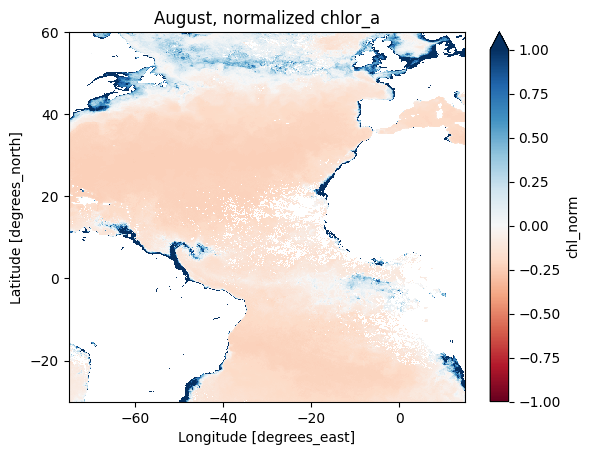

In [16]:
ds_merge.chl_norm[7].plot.imshow(cmap='RdBu', vmin=-1, vmax=1)
plt.title("August, normalized chlor_a")

### To PCA

In [114]:
vars_ = ["poc_norm", "chl_norm", "cphyto_norm", "pro", "syn", "pico"]
month_idx = 6 # try July first
mat   = ds_merge[vars_].isel(month=month_idx).to_array().values # .reshape(len(vars_), -1)
# remove nan
# mask = ( mat.notnull().sum(dim="variable") == 6 ).values

# remove nan and outliers?
mat[(np.abs(mat)>3)] = np.nan
mask = (np.nansum(mat==mat, axis=0)==6)

# select
mat_pca = mat[:, mask]


In [115]:
mat_pca.shape

(6, 454572)

In [116]:
pca = PCA(n_components=6)


In [117]:
# because it expects samples (observations) to be rows and features (variables) to be columns.
matrix_T = mat_pca.T
pca.fit(matrix_T)

PCA(n_components=6)

In [118]:
components = pca.components_
components.shape

(6, 6)

In [119]:
cov = pca.get_covariance()
cov.shape

(6, 6)

In [ ]:
# correlation matrix
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

corr  = correlation_from_covariance(cov)

In [120]:
pca.explained_variance_ratio_

array([0.64045346, 0.22091252, 0.08707484, 0.0357299 , 0.01478561,
       0.00104368], dtype=float32)

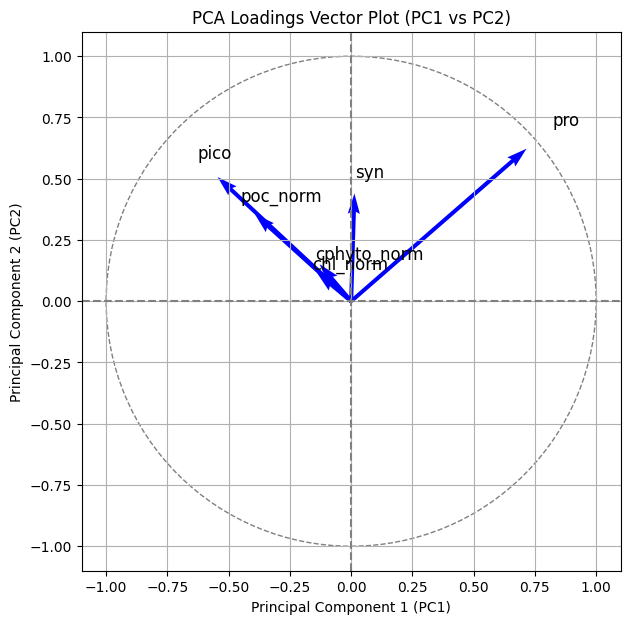

In [121]:
# Assuming the names for the 6 original variables.
variable_names = vars_

# Create the vector plot
plt.figure(figsize=(7, 7))

# Plot the vectors for the first two principal components (PC1 vs PC2)
plt.quiver(
    np.zeros(len(variable_names)),
    np.zeros(len(variable_names)),
    components[0, :],  # x-coordinates from PC1 loadings
    components[1, :],  # y-coordinates from PC2 loadings
    angles='xy',
    scale_units='xy',
    scale=1,
    color='b'
)

# Add labels for each vector. We place them slightly outside the tip of the arrow.
for i, name in enumerate(variable_names):
    plt.text(components[0, i] * 1.15, components[1, i] * 1.15, name, color='k', fontsize=12)

# Draw a unit circle to help visualize the magnitude of the loadings
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Set the axis labels and title
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Loadings Vector Plot (PC1 vs PC2)')
plt.grid()
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')

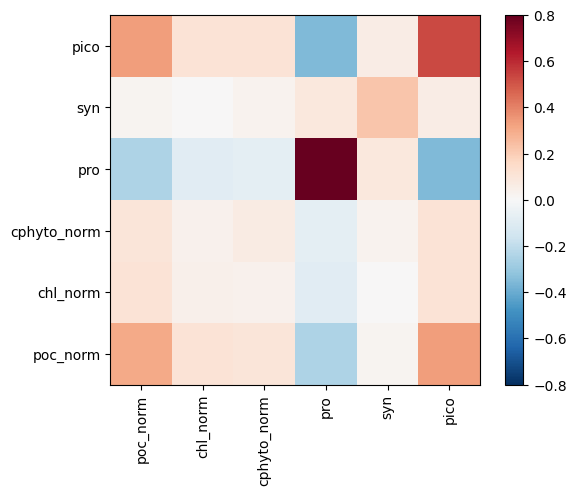

In [135]:
plt.imshow(cov, cmap="RdBu_r", vmin=-.8, vmax=.8)
plt.xticks(ticks=np.arange(len(vars_)), labels=vars_, rotation=90)
plt.yticks(ticks=np.arange(len(vars_)), labels=vars_)
plt.colorbar()
plt.gca().invert_yaxis()

### Loop over 12 months


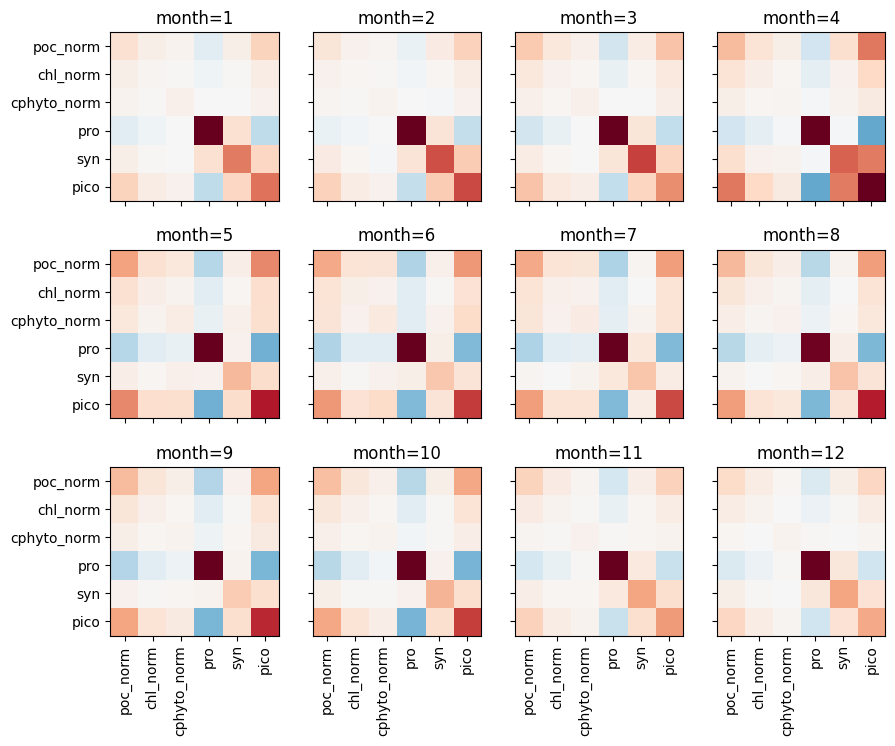

In [143]:
fig, axes = plt.subplots(3, 4, figsize=(10,8), sharex=True, sharey=True)
ax = axes.flatten()
for i in range(12):
    mat   = ds_merge[vars_].isel(month=i).to_array().values
    # remove nan
    # mask = ( mat.notnull().sum(dim="variable") == 6 ).values
    
    # remove nan and outliers?
    mat[(np.abs(mat)>3)] = np.nan
    mask = (np.nansum(mat==mat, axis=0)==6)
    
    # select
    mat_pca = mat[:, mask]

    # pca
    matrix_T = mat_pca.T
    pca.fit(matrix_T)

    ax[i].imshow(pca.get_covariance(), cmap="RdBu_r", vmin=-.8, vmax=.8)
    # ax[i].invert_yaxis()
    ax[i].set_xticks(ticks=np.arange(len(vars_)), labels=vars_, rotation=90)  
    ax[i].set_yticks(ticks=np.arange(len(vars_)), labels=vars_)  
    ax[i].set_title(f"month={i+1}")